### Setup

In [1]:
#Import
import pandas as pd
from pylab import *
%matplotlib inline
import seaborn
from GetPbP import get_additional_data_folder

#Read in data
df = pd.read_csv(get_additional_data_folder()+'tableau data.csv')
fwds = df[df.Pos == 'F'][['Player', 'Season', 'TOION(60s)', 'iG', 'iCF']]
fwds.rename(columns={'TOION(60s)': 'TOI'}, inplace=True)
fwds = fwds.groupby(['Player', 'Season']).sum()
fwds.reset_index(inplace=True)
fwds['G60'] = fwds['iG'] / fwds['TOI']

### Introduction

As of Tuesday morning, Sidney Crosby has 24 goals in 29 games. That's absolutely ridiculous: nearly a 70-goal pace per 82 games. His usual pace is in low-to-mid 30s; when he'd reached these heights before, it was in his first concussion-shortened season. His 24 so far represents about 12 more than what we'd ordinarily expect from him through 29 games played.

In [2]:
crosby = fwds[fwds.Player == 'Sidney Crosby']
crosby

,Player,Season,TOI,iG,iCF,G60
4974,Sidney Crosby,2007,16.907778,20,266,1.182888
4975,Sidney Crosby,2008,23.875556,29,321,1.214631
4976,Sidney Crosby,2009,22.691667,38,352,1.674624
4977,Sidney Crosby,2010,9.835556,20,163,2.033439
4978,Sidney Crosby,2011,6.276389,8,95,1.274618
4979,Sidney Crosby,2012,12.857778,17,206,1.322157
4980,Sidney Crosby,2013,23.512778,21,331,0.893131
4981,Sidney Crosby,2014,19.945000,18,275,0.902482
4982,Sidney Crosby,2015,26.058889,21,390,0.805867
4983,Sidney Crosby,2016,6.772500,14,104,2.067183


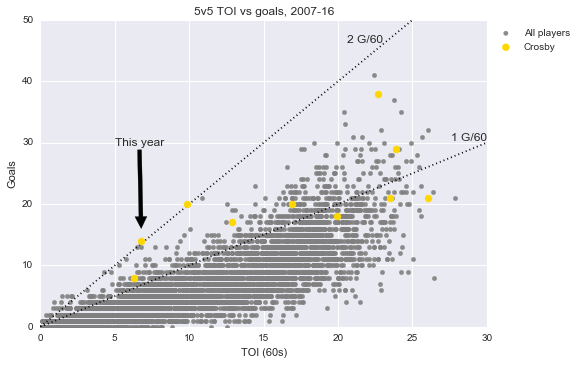

In [3]:
#Scatter: 5v5 TOI vs goals for forwards
scatter(fwds.TOI, fwds.iG, alpha = 0.9, label = 'All players', color = 'gray')
xlabel('TOI (60s)')
ylabel('Goals')
title('5v5 TOI vs goals, 2007-16')
xlim(left=0)
ylim(bottom=0)

#Label Crosby
crosby = fwds[fwds.Player == 'Sidney Crosby']
scatter(crosby.TOI, crosby.iG, color='gold', label='Crosby', s=50, zorder=2)
legend(loc=2, bbox_to_anchor=(1, 1))
annotate('This year', xy=(6.77, 16), xytext=(5, 30), arrowprops=dict(facecolor='k'), ha='left', va='center')

#Reference lines
plot([0, 30], [0, 30], ls=':', color='k', zorder=1)
annotate('2 G/60', xy=(23, 46), ha='right', va='bottom')
plot([0, 30], [0, 60], ls=':', color='k', zorder=1)
annotate('1 G/60', xy=(30, 30), ha='right', va='bottom')

It's unlikely Crosby keeps this up--no one recently has kept up 2 G/60 for an entire season, and few have even maintained 1.5.

In [4]:
fwds[(fwds.iG >= 30) & (fwds.G60 >= 1.5)]

,Player,Season,TOI,iG,iCF,G60
123,Alex Ovechkin,2007,23.745000,37,629,1.558223
125,Alex Ovechkin,2009,20.394722,35,576,1.716130
156,Alexander Semin,2009,18.373056,30,445,1.632826
1252,Corey Perry,2014,19.935278,30,346,1.504870
1899,Evgeni Malkin,2011,20.434722,33,344,1.614898
4976,Sidney Crosby,2009,22.691667,38,352,1.674624
5098,Steven Stamkos,2011,22.419444,41,340,1.828770


How many goals will Crosby score this year?
<p>As we did [before](https://github.com/muneebalam/Hockey/blob/master/NHL/Posts/CBJ%20Bayesian%20evaluation.ipynb), we can ditch the basic stats thinking from elementary school (which would lead to a prediction of over 60 goals--only Ovechkin and Stamkos have hit that mark since 1996) and use Bayesian thinking to get a better prediction.

### Simple prior
<p>Let's start with saying Crosby is "normal" and use the entire population of regular NHL forwards to create the prior. (We'll limit this to the top 270 in TOI each season to filter out the AHL call-ups, and exclude 2012-13 and 2016-17.)

In [5]:
#Filter population
season_toi_270 = fwds[(fwds.Season != 2013) & (fwds.Season != 2016)].groupby('Season').rank(method='first', ascending=False)
colnames = season_toi_270.columns
season_toi_270.rename(columns={col: col+'Rank' for col in colnames}, inplace=True)
season_toi_270.reset_index()
fwds_r = pd.concat([fwds, season_toi_270], axis=1)
fwds_r = fwds_r[fwds_r.TOIRank <= 270]
fwds_r.head()

,Player,Season,TOI,iG,iCF,G60,TOIRank,iGRank,iCFRank,G60Rank
27,Adam Burish,2010,12.307222,7,130,0.568772,269,242,281,304
29,Adam Burish,2012,7.814722,0,82,0.000000,258,441,275,441
41,Adam Hall,2010,18.424722,8,258,0.434199,93,216,93,373
46,Adam Henrique,2011,22.593611,15,194,0.663904,17,70,171,216
47,Adam Henrique,2012,8.980556,5,91,0.556758,213,183,246,259


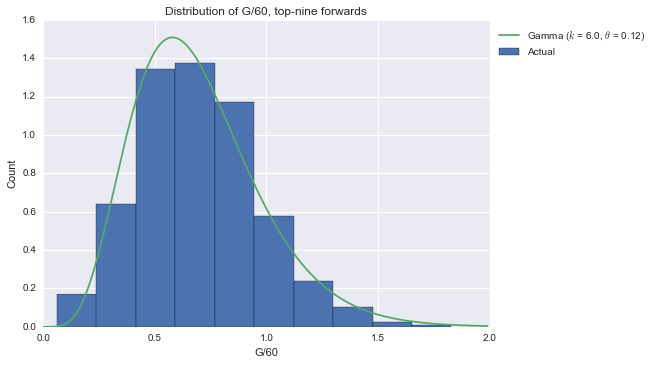

In [6]:
x = fwds_r[fwds_r.iG > 0]['G60']
xs = arange(0, 2, 0.01)

#plot
hist(x, normed=True, label='Actual')
xlabel('G/60')
ylabel('Count')
title('Distribution of G/60, top-nine forwards')

#Fit a gamma
from scipy.stats import gamma
k, loc, theta = gamma.fit(x, floc=0)
plot(xs, gamma.pdf(xs, k, loc, theta), label=r"Gamma ($k$ = {0:.1f}, $\theta$ = {1:.2f})".format(k, theta))
legend(loc=2, bbox_to_anchor=(1, 1))

I've taken the liberty of fitting a gamma distribution to the data. 
<p>In the Columbus post, we had a binomial variable in CF%. The distribution of CF% is the aggregation of this binomial variable over teams. The "sum" of the binomial (in a sense) is the beta distribution, so that's the distribution we fit then. 
<p>Similarly, G/60 is a "rate stat," which means something like the Poisson distribution might be appropriate (if we assume away things like independence of each event, which is not strictly true--you're a little more likely at certain times and less likely at others). Sum over the Poisson and you get a gamma. (The "discrete distributions" table [here](https://en.wikipedia.org/wiki/Conjugate_prior) is good reference.)
<p>Next, we need to update to the posterior. According to that Wikipedia link, with X new events in N new intervals, we update the parameters from 
<p>$\Gamma$(k, $\theta$) 
<p>to 
<p>$\Gamma$(k + X, $\theta$/(N$\theta$ + 1)).
<p>That's not quite as simple as the addition for the beta, but it's still pretty straightforward.

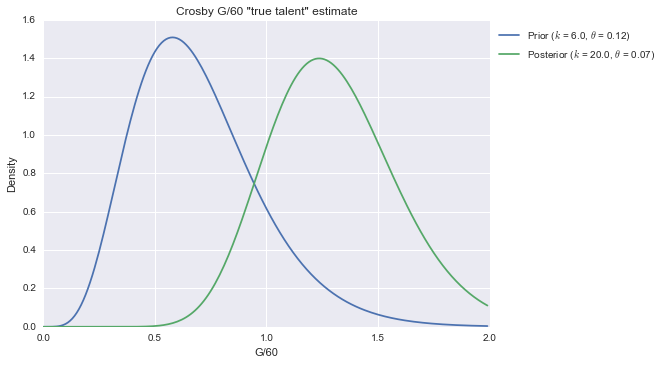

In [7]:
crosbyg = fwds.iloc[4983]['iG'] #See table above--Crosby 2016 is iloc 4983
crosbytoi = fwds.iloc[4983]['TOI']

plot(xs, gamma.pdf(xs, k, loc, theta), label=r"Prior ($k$ = {0:.1f}, $\theta$ = {1:.2f})".format(k, theta))

updated_k = k + crosbyg
updated_theta = theta/(theta*crosbytoi + 1)
plot(xs, gamma.pdf(xs, updated_k, loc, updated_theta), 
     label=r"Posterior ($k$ = {0:.1f}, $\theta$ = {1:.2f})".format(updated_k, updated_theta))

xlabel('G/60')
ylabel('Density')
title('Crosby G/60 "true talent" estimate')
legend(loc=2, bbox_to_anchor=(1, 1))

As we can see, with this prior, Crosby is likely not a "true talent" 2 G/60 player this year, torrid start notwithstanding. The green line pegs him at 1.3. 
<p>To project his year-end 5v5 goal total, we: 
<ul>
<li>See how many games Pittsburgh has left (47)
<li>Assume Crosby plays each of those remaining games (likely almost true)
<li>Project Crosby's current per-game TOI this year through the final 47 to get his total remaining TOI (11 "60s")
<li>Multiply by that goals rate to get his remaining goal projection (14)
<li>Add to his current total (14 in 29 GP) to get 28 5v5 goals.
</ul>
<p>Let's superimpose that on the first scatterplot.

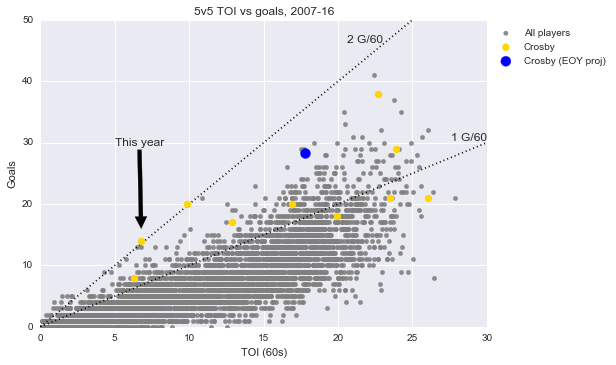

In [8]:
posterior_u = gamma.stats(updated_k, loc=loc, scale=updated_theta, moments='m')
crosbygp = 29
pit_gr = 47
crosby_toir = crosbytoi / crosbygp * pit_gr
crosby_gr = crosby_toir * posterior_u

crosby_projtoi = crosbytoi + crosby_toir
crosby_projg = crosbyg + crosby_gr

#Scatter: 5v5 TOI vs goals for forwards
scatter(fwds.TOI, fwds.iG, alpha = 0.9, label = 'All players', color = 'gray')
xlabel('TOI (60s)')
ylabel('Goals')
title('5v5 TOI vs goals, 2007-16')
xlim(left=0)
ylim(bottom=0)

#Label Crosby
crosby = fwds[fwds.Player == 'Sidney Crosby']
scatter(crosby.TOI, crosby.iG, color='gold', label='Crosby', s=50, zorder=2)
annotate('This year', xy=(6.77, 16), xytext=(5, 30), arrowprops=dict(facecolor='k'), ha='left', va='center')

#Year-end projection
scatter([crosby_projtoi], [crosby_projg], color='b', label='Crosby (EOY proj)', zorder=2, s=100)

legend(loc=2, bbox_to_anchor=(1, 1))

#Reference lines
plot([0, 30], [0, 30], ls=':', color='k', zorder=1)
annotate('2 G/60', xy=(23, 46), ha='right', va='bottom')
plot([0, 30], [0, 60], ls=':', color='k', zorder=1)
annotate('1 G/60', xy=(30, 30), ha='right', va='bottom')

That's pretty great, but also a considerable slowdown from his current pace. 
<p>We can also use the posterior distribution to construct "credibility intervals" for his year-end goal total. The posterior gives us probabilities for different "true values" of Crosby's goals rate. We can tie those to the remaining TOI we calculated above, assume he scores at his "true" goals rate for the rest of the year, and get a range of possibilities for his year-end goal total.

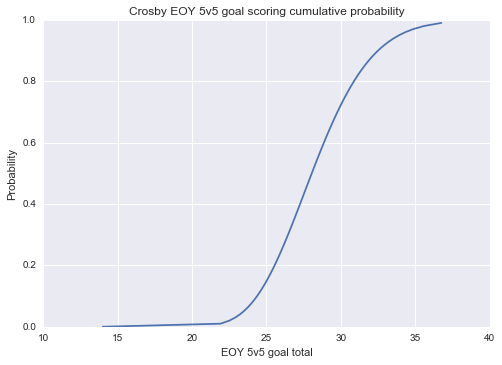

In [9]:
probs = arange(0, 1.01, 0.01)
crosby_g_probs = crosbyg + crosby_toir * gamma.ppf(probs, updated_k, loc, updated_theta)
plot(crosby_g_probs, probs, label='Cumulative')
ylabel('Probability')
xlabel('EOY 5v5 goal total')
title('Crosby EOY 5v5 goal scoring cumulative probability')

This chart shows the cumulative probability. The first point is at (14, 0)--we're certain that he'll get to 14 (because he's already there). There's another point around (25, 0.18). Given our assumptions above, there's about an 18% chance he doesn't get to 25. Similarly, there's about a 70% chance he doesn't get to 30. And he's about 95% likely to fall short of 35.

### A better prior
<p>This is all well and good, but we've drawn Crosby from the population of top-nine players. This is obviously unflattering to him--he's probably the best player in the league, and if not, he's second. 
<p>We can try finding a population of players to draw him from, but when we take the top scorers over this time period, we see he's first. 

In [10]:
topfwds = fwds.groupby('Player').sum()
topfwds.reset_index(inplace=True)
topfwds['G60'] = topfwds['iG'] / topfwds['TOI']
topfwds = topfwds[topfwds.TOI >= 50]
topfwds.sort_values('G60', inplace=True, ascending=False)
topfwds.head(6)

,Player,Season,TOI,iG,iCF,G60
1230,Steven Stamkos,18108,148.823611,185,2219,1.243082
30,Alex Ovechkin,20115,200.696944,246,4990,1.225729
1200,Sidney Crosby,20115,168.733889,206,2503,1.220857
1340,Vladimir Tarasenko,10070,72.127778,84,1417,1.164600
1093,Rick Nash,20115,164.332778,185,3125,1.125764
982,Nikita Kucherov,8058,60.810556,68,902,1.118227


Let's just take the individual player-seasons for these five (the only ones above 1.1 G/60) to form a prior, and re-run the analysis. I'd say we should be more optimistic on Crosby than the results say because he's better than this "peer" group of 48 player-seasons, but on the other hand, most of these peak seasons came in the respective players' primes (i.e. mid-20s), and Crosby is 29.

48


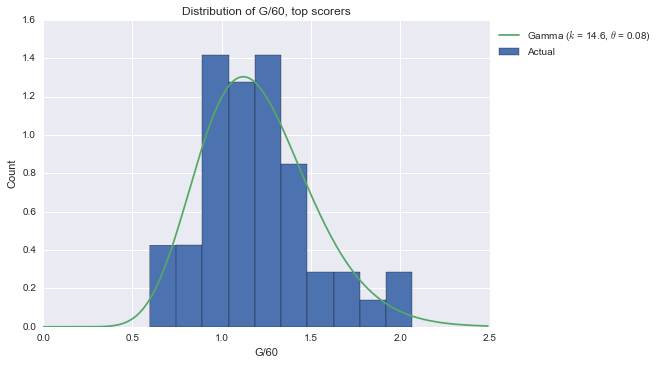

In [ ]:
fwds_filtered = fwds[(fwds.Player == 'Steven Stamkos') | (fwds.Player == 'Alex Ovechkin') | 
                     (fwds.Player == 'Sidney Crosby') | (fwds.Player == 'Vladimir Tarasenko') | 
                    (fwds.Player == 'Rick Nash') | (fwds.Player == 'Nikita Kucherov')]
print(len(fwds_filtered))

x = fwds_filtered['G60']
xs = arange(0, 2.5, 0.01)

#plot
hist(x, normed=True, label='Actual')
xlabel('G/60')
ylabel('Count')
title('Distribution of G/60, top scorers')

#Fit a gamma
k_top, loc_top, theta_top = gamma.fit(x, floc=0)
plot(xs, gamma.pdf(xs, k_top, loc_top, theta_top), 
     label=r"Gamma ($k$ = {0:.1f}, $\theta$ = {1:.2f})".format(k_top, theta_top))
legend(loc=2, bbox_to_anchor=(1, 1))

Our old prior was centered around 0.6. The new prior is nearly double that.
<p>Let's see the effect on the posterior.

In [ ]:
plot(xs, gamma.pdf(xs, k, loc, theta), label=r"Old Prior ($k$ = {0:.1f}, $\theta$ = {1:.2f})".format(k, theta),
    color='b', ls='--')
plot(xs, gamma.pdf(xs, updated_k, loc, updated_theta), color='g', ls='--',
     label=r"Old Posterior ($k$ = {0:.1f}, $\theta$ = {1:.2f})".format(updated_k, updated_theta))

plot(xs, gamma.pdf(xs, k_top, loc_top, theta_top), color='b', ls='-',
     label=r"New Prior ($k$ = {0:.1f}, $\theta$ = {1:.2f})".format(k_top, theta_top))

updated_k_top = k_top + crosbyg
updated_theta_top = theta_top/(theta_top*crosbytoi + 1)
plot(xs, gamma.pdf(xs, updated_k_top, loc_top, updated_theta_top), color='g', ls='-',
     label=r"New Posterior ($k$ = {0:.1f}, $\theta$ = {1:.2f})".format(updated_k_top, updated_theta_top))

xlabel('G/60')
ylabel('Density')
title('Crosby G/60 "true talent" estimate')
legend(loc=2, bbox_to_anchor=(1, 1))

Blue is the prior and green the posterior; the solid lines come from this new "top scorers" population, while the dashed is what we had before--the top-nine forwards population. The center moves to the right by about 20%. That's more modest than the movement in the prior, but still significant.
<p>Here's the effect on the goal projections.

In [ ]:
crosby_g_probs_top = crosbyg + crosby_toir * gamma.ppf(probs, updated_k_top, loc_top, updated_theta_top)
plot(crosby_g_probs_top + 2, probs, label='Cumulative (new, adj)', ls=':')
plot(crosby_g_probs_top, probs, label='Cumulative (new)')
plot(crosby_g_probs, probs, label='Cumulative (old)', ls='--')
ylabel('Probability')
xlabel('EOY 5v5 goal total')
title('Crosby EOY 5v5 goal scoring cumulative probability')
legend(loc=2, bbox_to_anchor=(1, 1))

For the same probability, we're projecting two or three more goals using a top scorer cohort (solid green) than the top-nine forward group (dashed red). 
<p>Given that Crosby is still the class of the cohort we used, I added a third line (dotted blue) that gives him an extra two-goal edge over the solid green line. Under the blue, we're pretty sure Crosby can get to 30 (80%), think it's possible he gets to 35 (20%), and even see a small chance of 40.

### Conclusion
Sidney Crosby is really good, but it's unlikely he'll keep up his current goals pace. He'll probably fall back into something around 1.5 G/60 at 5v5, positioning himself for 30-35 ES goals and around 45-50 goals by the end of the season.